In [1]:
%autosave 0

Autosave disabled


# Introduction

Objectif : 
- Créer un pipeline de re entrainement et drop du modéle 
- Créer un pipeline de consommation du modéle

Je re import mes scripts crées dans le nb 02 , 
comme je suis dans un dossier paralélle à ma lib je dois avoir une importation différente.
Dans ce note book je ne droperai pas les scripts avec l'outils %% writeline mais je copierai mon code dans des scripts python à la racine ou dans lib avec les modifications nécassire par rapport à l'archi du repo.

- PS : il y'a plein de façon de faire ce qui va être fait dans ce notebook, mon idée ici étant de me le créer sur mesure, mais en fonction des choix de déploiement d'un modéle ca necessiterai ajustement

- PS2 : Les docstrings seront ajoutées au script python pas ici 

In [2]:
import sys
sys.path.append('..')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd


import lib
from lib.data_clean import DataClean
from lib.classifier_trainer import ClassifierJob
from lib.plot import roc

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from joblib import dump, load
from lib import consume_validation
from lib.data_explore import DataExplore
import datetime

from sklearn import metrics

Je reprend les solutions du nb 02 :

# Custom train pipeline

In [3]:
class custom_train_pip():
    
    def __init__(self,df_init):
        self.df = df_init
        self.df_clean = None
        self.model_train = None
        self.unique_key = str(datetime.datetime.now()).replace(" ","_").replace(":","_").replace(".","_")
        
    def clean_job(self):
        try:
            cleandata = DataClean(self.df)
            self.df_clean = cleandata.clean_job() ### SET cleandata.clean_job(self.unique_key) if databricks needed
            return self.df_clean
        except Exception as e:
            raise Exception(f"clean failed : {e}")
    
    def retrain_job(self, model_init, test_size=0.2, seed=69, learning_curve_mod=False, normalize=False, 
                    list_col_name_drop=None):
        try:
            cl = ClassifierJob(self.df_clean,model_init)
            if list_col_name_drop != None:
                x_full, y_full = cl.split_features_target(list_col_name_drop)
            else:
                x_full, y_full = cl.split_features_target()
            self.model_train = cl.fit_and_eval(test_size, seed,
                                            learning_curve_mod=learning_curve_mod, normalize=normalize)
            return self.model_train
        except Exception as e:
            raise Exception(f"Train failed : {e}")
    
    def drop_model(self):
        if (self.model_train != None):
            try:
                path = str(f'../Model/clf_model_{self.unique_key}.joblib')
                dump(self.model_train, path)
                return str(f"Model succesfully Create at {self.unique_key}")
            except Exception as e:
                raise Exception(f"Create model failed : {e}")
        else:
            raise Exception(f"Create model failed : self.model_train == None")

Score train : 1.0
-----------
Score test : 0.91
-----------
AUC: 0.96 (std:0.0108), (splits = 5)


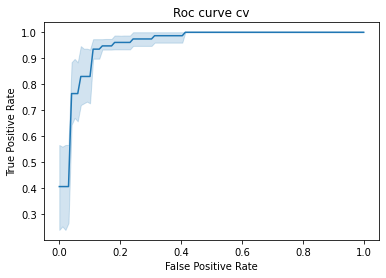

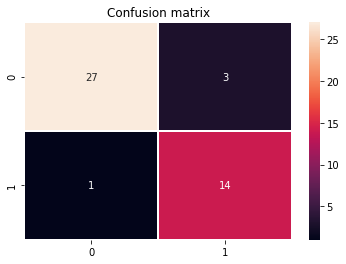

--------
Classification reporting
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93        30
         1.0       0.82      0.93      0.87        15

    accuracy                           0.91        45
   macro avg       0.89      0.92      0.90        45
weighted avg       0.92      0.91      0.91        45



In [4]:
## je reprends les données de train de base et je reproduis l'expérience
init_df = pd.read_excel("../data/Données projet LAP Cas-témoin 02-10-20.xlsx")
model_retrain = xgb.XGBClassifier(n_estimators=300, max_depth=2)

## instance de toute la pipeline de rentrainement
train_job = custom_train_pip(init_df)
train_job.clean_job()

list_col_name_drop = ['Sex_M_F_(0_1)', 'Hematies_(T_L)', 'Mono_(G_L)', 'PNE_(%)',
       'Hemoglobine_(g_L)', 'Hematocrite_(%)', 'TCMH_(pg)','IDR-CV_(%)', 'PNN_(%)',
       'PNE_(G_L)', 'PNB_(%)', 'PNB_(G_L)', 'Lymphos_(G_L)',
       'Mono_(%)', 'Blastes_(%)', 'Plq_(G_L)', 'VPM_(fL)',
       'Ret_(G_L)', 'Ratio_TCA_',
       'PDF_(ug_mL)_', 'LDH_(U_L)', 'Calcium_(Ca2+)_(mmol_L)',
       'Phosphore_(mmol_L)', 'Uree_(mmol_L)', 'Creatinine',
       'Acide_urique_(umol_L)', 'Ferritine_(ug_L)', 'CRP_(mg_L)']



## Precision : si normalize=True le joblib contiandra le job de standardscaler, 
## on aura rien à faire pour la consommation du model 
model = train_job.retrain_job(model_retrain,normalize=False,list_col_name_drop=list_col_name_drop) 

Le bloc ci dessous drop le modéle dans le dossier.
Il a un id unique dans son nom (date et heure).

In [6]:
# get_return = train_job.drop_model()
# print(get_return)

In [6]:
# Visualiser ce que contient le modéle qui a été drop

# Example si normalized :
#     Pipeline(steps=[('pipeline',
#                  Pipeline(steps=[('standardscaler', StandardScaler())])),
#                 ('gradientboostingclassifier', GradientBoostingClassifier())])
#  sinon :
#         GradientBoostingClassifier()
        

model 

XGBClassifier(max_depth=2, n_estimators=300)

# Observation du Train

on retrouve nos éléments de train, on doit rajouter une condition avant le drop du modéle par exemple si on souhaite automatiser le projet

 - if accuracy > a 0.93 and accuracy_classe_1 >0.88:
     // drop job

dans ce projet on a pas stockées ces informations mais si on avait un deploiement cloud on peut, ou alors depuis une bdd dans un env docker ect...

# Consommer le modéle 

In [7]:
def iso_id(df,p_number):
    """return df with only data for patient number"""
    df = df[df['Patient_numbers'].isin([p_number])]
    return df


# toutes les data de  validations ensemble
validation_df = pd.read_csv("../data/cohorte_full_data.csv")
validation_df

,Chu,Patient_numbers,target,Age,Leucocytes (G/L),VGM (fL),CCMH (g/L),PNN (G/L),Lymphos_(%),TP (%),Fibrinogene (g/L),PNE (%),Mono_(G_L),LDH (U/L),Plq_(G_L)
0,Grenoble,1,1.0,4.0,3.60,84.0,354.0,0.80,63.9,67.0,2.9,0.0,0.0,363,7.0
1,Grenoble,2,1.0,46.0,7.10,77.3,349.0,4.50,23.9,55.0,2,0.0,0.6,888,47.0
2,Grenoble,3,1.0,52.0,1.90,83.4,360.0,7.00,36.8,80.0,1.1,1.0,0.0,477,30.0
3,Grenoble,4,1.0,49.0,1.00,102.3,348.0,0.10,80.0,94.0,3.1,0.0,0.0,90,35.0
4,Grenoble,5,1.0,49.0,1.10,91.1,341.0,0.40,36.4,86.0,3.1,0.0,0.0,168,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,Lyon_Pros,268,1.0,35.0,37.64,88.6,337.0,0.38,6.0,72.0,0.83,NaN,NaN,NaN,NaN
411,Lyon_Pros,269,1.0,55.0,3.22,102.0,325.0,0.64,47.0,58.0,0.41,NaN,NaN,NaN,NaN
412,Lyon_Pros,270,1.0,48.0,6.05,97.6,338.0,0.00,10.0,86.0,2.29,NaN,NaN,NaN,NaN
413,Lyon_Pros,271,1.0,71.0,2.60,90.8,345.0,1.41,28.5,91.0,3.14,NaN,NaN,NaN,NaN


In [8]:
list_col_name_drop = ["PNE_(%)", "Mono_(G_L)", "Plq_(G_L)", "LDH_(U_L)","Chu"]

In [9]:
# validation_df.head(10)
# validation_df = iso_id(validation_df,42)
dataviz = DataExplore(validation_df)
na_count = dataviz.count_na()
len(na_count)

11

In [10]:
na_count

,Total,Null_Count,Percent
LDH (U/L),415,92,22.17
PNE (%),415,59,14.22
Mono_(G_L),415,59,14.22
Plq_(G_L),415,50,12.05
Fibrinogene (g/L),415,20,4.82
TP (%),415,14,3.37
Lymphos_(%),415,10,2.41
PNN (G/L),415,9,2.17
Age,415,1,0.24
VGM (fL),415,1,0.24


In [11]:
id_list = validation_df["Patient_numbers"]
id_list = [str(element) for element in id_list]

Score Validation : 0.91


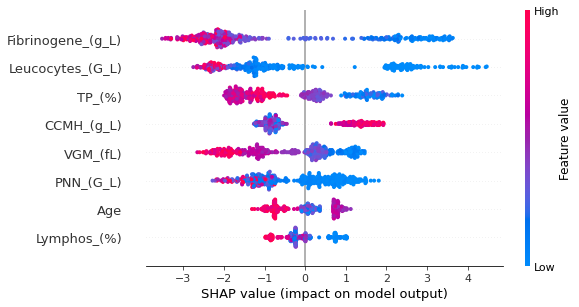

In [12]:
## Test pour charger le modèle depuis le joblib
model = load("../Model/clf_model_2021-03-05_15_13_20_270634.joblib") 
databrick = load("../Model/databrick_model_2021-02-21_14_37_04_740893.joblib") 

## Bloc pour excécuter la prédiction, il est en mode notebook, il est plus simple sur le sricpt.
cleandata = DataClean(validation_df)
validation_df = cleandata.prod_clean_job(databrick)
cl = ClassifierJob(validation_df,model)
x_valid, y_valid = cl.split_features_target(list_col_name_drop) #list_col_name_drop

m_val_step = consume_validation.ConsumeModelClf(x_valid,model,validation=True,true_y=y_valid.values)
m_val_step.predict_job()

## retourne la matrice de résultat dans un df et expose la figure explicative
final_df = m_val_step.show_result()
m_val_step.explain()

In [13]:
final_df["Id"] = id_list
final_df

,Id,Predictions,Trust%,True_value
0,1,0.0,74.37,1.0
1,2,1.0,93.55,1.0
2,3,1.0,99.74,1.0
3,4,0.0,90.18,1.0
4,5,0.0,76.40,1.0
...,...,...,...,...
410,268,1.0,83.29,1.0
411,269,1.0,55.84,1.0
412,270,0.0,97.10,1.0
413,271,0.0,99.74,1.0


In [14]:
def apply_thresh(df,thres=95):
    if df["Predictions"] == 0.0 :
        if df["Trust%"] <=thres:
            return 1.0
        else:
            return 0.0
    else:
        return 1.0     

In [15]:
final_df['Correction'] = final_df.apply(apply_thresh, axis=1)

In [16]:
final_df

,Id,Predictions,Trust%,True_value,Correction
0,1,0.0,74.37,1.0,1.0
1,2,1.0,93.55,1.0,1.0
2,3,1.0,99.74,1.0,1.0
3,4,0.0,90.18,1.0,1.0
4,5,0.0,76.40,1.0,1.0
...,...,...,...,...,...
410,268,1.0,83.29,1.0,1.0
411,269,1.0,55.84,1.0,1.0
412,270,0.0,97.10,1.0,0.0
413,271,0.0,99.74,1.0,0.0


In [17]:
def details_score(final_df, key_analytics='Correction'):
    ac = metrics.accuracy_score(final_df['True_value'].values, final_df[f'{key_analytics}'].values)
    print("Score :",round(ac,2))
    df_cl1 = final_df[final_df['True_value'].isin([1.0])]
    df_cl1 = df_cl1.reset_index()
    ac = metrics.accuracy_score(df_cl1['True_value'].values, df_cl1[f'{key_analytics}'].values)
    print("Score classe 1 :",round(ac,2))
    df_cl0 = final_df[final_df['True_value'].isin([0.0])]
    ac = metrics.accuracy_score(df_cl0['True_value'].values, df_cl0[f'{key_analytics}'].values)
    print("Score classe 0 :",round(ac,2))
    return df_cl1
    

In [18]:
print("Sans Seuil")
print("------")
df_cl1 = details_score(final_df, key_analytics='Predictions')

print("------------------------------")

print("Avec Seuil")
print("------")
df_cl1 = details_score(final_df)

Sans Seuil
------
Score : 0.91
Score classe 1 : 0.84
Score classe 0 : 0.94
------------------------------
Avec Seuil
------
Score : 0.84
Score classe 1 : 0.96
Score classe 0 : 0.79


In [19]:
def apply_is_error(df):
    if df["Predictions"] == df["True_value"]:
        return 0
    else:
        return 1
    
final_df['is_error'] = final_df.apply(apply_is_error, axis=1)
error_df = final_df[final_df["is_error"].isin([1])]
error_df = error_df.drop(columns=["is_error"])
error_df 

,Id,Predictions,Trust%,True_value,Correction
0,1,0.0,74.37,1.0,1.0
3,4,0.0,90.18,1.0,1.0
4,5,0.0,76.40,1.0,1.0
9,10,0.0,76.58,1.0,1.0
36,38,0.0,98.64,1.0,0.0
40,42,0.0,95.11,1.0,0.0
43,45,0.0,77.21,1.0,1.0
60,69,1.0,86.19,0.0,1.0
80,91,1.0,60.80,0.0,1.0
86,100,1.0,79.17,0.0,1.0


:) un resultat trés positif car le fichier de validation est 10/15 fois plus gros que notre fichier de test lors du train.
Le fichier de validation 2 est aussi gros que le dataset complet de base.

# --Fin--